# Spine segmentation training and evaluation 

## U-Net and TverskyFocal

In [ ]:
from fastMONAI.vision_all import *
from monai.networks.nets import UNet

In [ ]:
loss_func = CustomLoss(loss_func=TverskyFocalLoss(to_onehot_y=True, include_background=True, softmax=True))
model = UNet(spatial_dims=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2)
model = model.model

Skip to inference part if you want to reproduce the test results from our paper and export the learner for inference on own data `01-spine-segmentation-inference.ipynb`. 

## Train your own model 

In [ ]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'..'/'data'/'ADD_PATH' 

In [ ]:
fold = 0
df = pd.read_csv(DATA_DIR/'FILENAME.csv')
df.loc[df.fold == fold, 'is_val'] = True 

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=df.t2_img_path.tolist(), reorder=True, max_workers=12)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([4.4, 0.7813, 0.7812], True)

In [ ]:
bs=4

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[17.0, 385.0, 385.0]

In [ ]:
size = [16,400,400]

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), 
             RandomGamma(log_gamma=(-0.2,0.2), p=0.5), RandomAffine(scales=(0.9, 1.1), degrees=5, p=0.5), 
             RandomElasticDeformation(num_control_points=5, max_displacement=5.5, p=0.5)]

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_val'),
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(12, 3)

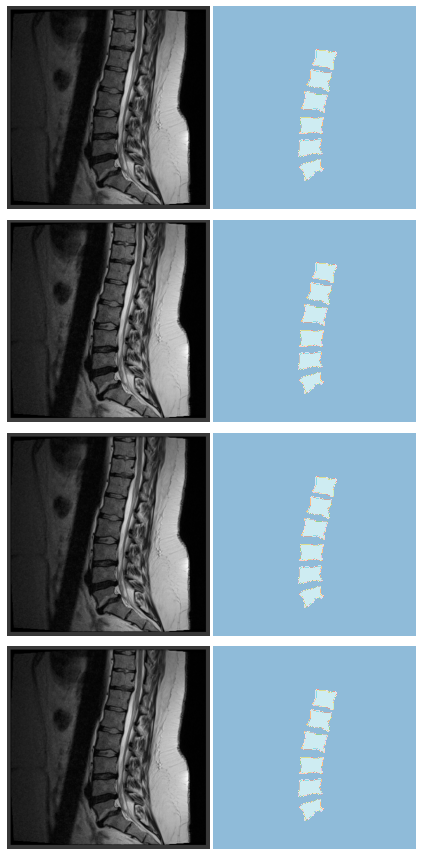

In [ ]:
dls.show_batch(unique=True, anatomical_plane=0) 

### Create learner

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[multi_dice_score])

SuggestedLRs(valley=0.001737800776027143)

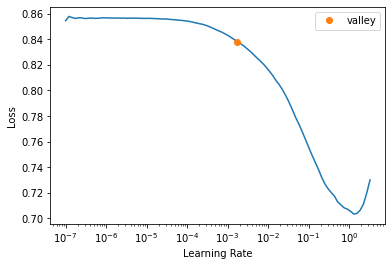

In [ ]:
lr=learn.lr_find()
lr 

In [ ]:
learn.fit_flat_cos(20 ,lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.928294,0.928677,0.044645,00:08
1,0.928016,0.923513,0.052688,00:07
2,0.924045,0.908607,0.080501,00:08
3,0.918574,0.904859,0.086175,00:08
4,0.913953,0.889326,0.134398,00:08
5,0.908712,0.893041,0.081170,00:07
6,0.904902,0.872140,0.155407,00:08
7,0.899027,0.867702,0.163421,00:07
8,0.893693,0.844026,0.210017,00:07
9,0.886025,0.841773,0.197393,00:07


In [ ]:
learn.save('custom-model')

In [ ]:
store_variables(pkl_fn=Path('models/vars.pkl'), var_vals=[size, reorder, resample])

## Inference on test data

In [ ]:
from huggingface_hub import snapshot_download
from fastMONAI.research_utils import * 

In [ ]:
size, reorder, resample = load_variables(pkl_fn='models/vars.pkl')
size, reorder, resample

([16, 400, 400], True, [4.4, 0.78, 0.78])

### Download trained weights

In [ ]:
models_path = snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='models', allow_patterns="*.pth")
model_list = list(Path(models_path).glob('*.pth'))
model_list = ['/'.join((fn.parts[1:])) for fn in model_list]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

### Download external data and create DataFrame

In [ ]:
external_data = snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='data', allow_patterns="*.zip")
shutil.unpack_archive(Path(external_data)/'external_t2w_spine.zip', 'data')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
DATA_DIR = Path('data/external_t2w_spine')

In [ ]:
img_list = glob.glob(str(DATA_DIR/'img/*.nii.gz'))
mask_list = [str(fn).replace('img', 'seg') for fn in img_list]
subject_id_list = [fn.split('_')[-1].split('.')[0] for fn in img_list]

In [ ]:
example_data = {'t2_img_path':'example_data/img.nii.gz', 't2_mask_path':'example_data/img.nii.gz', 'subject_id':-1, 'is_test':False}
test_data = {'t2_img_path':img_list, 't2_mask_path':mask_list, 'subject_id':subject_id_list, 'is_test':True}

df = pd.DataFrame(pd.concat([pd.DataFrame(example_data, index=[0]), pd.DataFrame(test_data)], ignore_index=True))

### Create MedDataBlock

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size)]

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_test'),
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=4)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger)

In [ ]:
_, labels = learn.get_preds()
labels.shape

torch.Size([23, 1, 16, 400, 400])

### Predict on test data and export learner 

In [ ]:
n_folds=3
ensemble_acts = None
for idx, fn in enumerate(model_list): 
    learn.load(str(fn).split('.')[0])
    learn.export(f'models/{idx}_learner.pkl')
    
    pred_acts, _ = learn.get_preds()
        
    ensemble_acts = pred_acts if ensemble_acts is None else ensemble_acts + pred_acts

ensemble_acts = ensemble_acts/n_folds

In [ ]:
pred_masks,_ = batch_pred_to_multiclass_mask(ensemble_acts)

In [ ]:
raw_ensemble_dsc = calculate_dsc(pred_masks, labels)

In [ ]:
torch.mean(raw_ensemble_dsc), torch.std(raw_ensemble_dsc)

(tensor(0.8956), tensor(0.0212))

In [ ]:
raw_ensemble_haus = calculate_haus(pred_masks, labels)
torch.mean(raw_ensemble_haus),torch.std(raw_ensemble_haus)

(tensor(53.3998), tensor(39.7330))

In [ ]:
post_pred_masks = [torch.Tensor(pred_postprocess(pred)) for pred in pred_masks]

In [ ]:
post_dsc = calculate_dsc(post_pred_masks, labels)
torch.mean(post_dsc), torch.std(post_dsc)

(tensor(0.8990), tensor(0.0199))

In [ ]:
post_haus = calculate_haus(post_pred_masks, labels)
torch.mean(post_haus), torch.std(post_haus)

(tensor(12.0519), tensor(11.6195))

In [ ]:
df_test = df[1:].copy()
df_test['raw_ensemble_dsc'] = raw_ensemble_dsc
df_test['raw_ensemble_haus'] = raw_ensemble_haus
df_test['postprocessed_ensemble_dsc'] = post_dsc
df_test['postprocessed_ensemble_haus'] = post_haus
df_test = df_test.sort_values('subject_id').reset_index(drop=True)

In [ ]:
df_test

,t2_img_path,t2_mask_path,subject_id,is_test,raw_ensemble_dsc,raw_ensemble_haus,postprocessed_ensemble_dsc,postprocessed_ensemble_haus
0,data/external_t2w_spine/img/Img_01.nii.gz,data/external_t2w_spine/seg/Img_01.nii.gz,01,True,0.918600,19.052559,0.921241,6.708204
1,data/external_t2w_spine/img/Img_02.nii.gz,data/external_t2w_spine/seg/Img_02.nii.gz,02,True,0.917546,4.242640,0.917546,4.242640
2,data/external_t2w_spine/img/Img_03.nii.gz,data/external_t2w_spine/seg/Img_03.nii.gz,03,True,0.868997,66.392769,0.880941,35.468296
3,data/external_t2w_spine/img/Img_04.nii.gz,data/external_t2w_spine/seg/Img_04.nii.gz,04,True,0.877634,18.601076,0.877997,18.601076
4,data/external_t2w_spine/img/Img_05.nii.gz,data/external_t2w_spine/seg/Img_05.nii.gz,05,True,0.926372,86.261230,0.927981,7.071068
5,data/external_t2w_spine/img/Img_06.nii.gz,data/external_t2w_spine/seg/Img_06.nii.gz,06,True,0.913778,8.062258,0.913778,8.062258
6,data/external_t2w_spine/img/Img_07.nii.gz,data/external_t2w_spine/seg/Img_07.nii.gz,07,True,0.883685,110.607414,0.902101,5.000000
7,data/external_t2w_spine/img/Img_08.nii.gz,data/external_t2w_spine/seg/Img_08.nii.gz,08,True,0.922395,5.477226,0.922395,5.477226
8,data/external_t2w_spine/img/Img_09.nii.gz,data/external_t2w_spine/seg/Img_09.nii.gz,09,True,0.900216,87.344147,0.901496,8.660254
9,data/external_t2w_spine/img/Img_10.nii.gz,data/external_t2w_spine/seg/Img_10.nii.gz,10,True,0.909385,64.101479,0.909481,4.582576
